In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import classification_report
import timm
import numpy as np

# 기존 모델 파일 삭제
for file in ["photo_pretrained_dino.pth", "best_photo_model.pth", "best_drawing_model.pth"]:
    if os.path.exists(file):
        os.remove(file)

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📌 디바이스: {device}")

/workspace/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📌 디바이스: cuda


In [2]:
# 하이퍼파라미터
BATCH_SIZE = 16
LR_PHOTO = 1e-4
LR_DRAWING = 1e-5
EPOCHS_PHOTO = 15
EPOCHS_DRAWING = 30

In [3]:
# 224x224 전처리 (DINOv2 최적화)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# train/val 나누기 (일관된 분할)
def split_dataset_consistent(dataset_train, dataset_val):
    total_size = len(dataset_train)
    train_size = int(0.8 * total_size)
    val_size = total_size - train_size

    generator = torch.Generator().manual_seed(42)
    train_indices, val_indices = random_split(range(total_size), [train_size, val_size], generator=generator)

    train_subset = torch.utils.data.Subset(dataset_train, train_indices.indices)
    val_subset = torch.utils.data.Subset(dataset_val, val_indices.indices)

    return train_subset, val_subset

# 데이터셋 로드
photo_dataset_train = datasets.ImageFolder('datasets/dataset2yolo/photo', transform=transform_train)
photo_dataset_val = datasets.ImageFolder('datasets/dataset2yolo/photo', transform=transform_val)
drawing_dataset_train = datasets.ImageFolder('datasets/dataset2yolo/drawing', transform=transform_train)
drawing_dataset_val = datasets.ImageFolder('datasets/dataset2yolo/drawing', transform=transform_val)

photo_train, photo_val = split_dataset_consistent(photo_dataset_train, photo_dataset_val)
drawing_train, drawing_val = split_dataset_consistent(drawing_dataset_train, drawing_dataset_val)

# 데이터 로더
photo_train_loader = DataLoader(photo_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
photo_val_loader = DataLoader(photo_val, batch_size=BATCH_SIZE, num_workers=4)
drawing_train_loader = DataLoader(drawing_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
drawing_val_loader = DataLoader(drawing_val, batch_size=BATCH_SIZE, num_workers=4)

print(f"📊 데이터셋 크기:")
print(f"사진 - 학습: {len(photo_train)}, 검증: {len(photo_val)}")
print(f"그림 - 학습: {len(drawing_train)}, 검증: {len(drawing_val)}")
print(f"클래스: {photo_dataset_train.classes}")

📊 데이터셋 크기:
사진 - 학습: 5756, 검증: 1440
그림 - 학습: 1608, 검증: 403
클래스: ['train', 'val']


### Dinov2 + Transformer

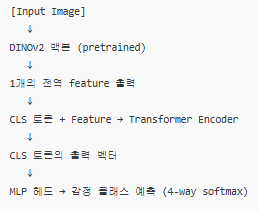

In [4]:
class DinoTransformerClassifier(nn.Module):
    def __init__(self, model_name='vit_small_patch14_dinov2.lvd142m', num_classes=4, dropout=0.1):
        super().__init__()
        
        # DINOv2 백본 로드 (사전훈련된 특성 추출기)
        self.backbone = timm.create_model(model_name, pretrained=True, img_size=224)
        self.backbone.reset_classifier(0)  # 기존 분류기 제거
        
        # 초기에는 백본 가중치 고정 (특성 추출기로만 사용)
        for param in self.backbone.parameters():
            param.requires_grad = False

        # 분류 헤드 (개선된 구조)
        self.head = nn.Sequential(
            nn.LayerNorm(self.backbone.num_features),
            nn.Dropout(dropout),
            nn.Linear(self.backbone.num_features, 512),
            nn.GELU(),
            nn.Dropout(dropout * 1.5),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # DINOv2 특성 추출
        features = self.backbone.forward_features(x)  # [B, num_patches+1, embed_dim]
        
        # CLS 토큰 추출 (첫 번째 토큰)
        cls_token = features[:, 0]  # [B, embed_dim]
        
        # 분류 헤드 통과
        return self.head(cls_token)

    def unfreeze_backbone_layers(self, num_layers=2):
        """백본의 마지막 레이어들을 언프리징"""
        total_blocks = len(self.backbone.blocks)
        for i in range(total_blocks - num_layers, total_blocks):
            for param in self.backbone.blocks[i].parameters():
                param.requires_grad = True
        
        # norm layer도 언프리징
        for param in self.backbone.norm.parameters():
            param.requires_grad = True
        
        print(f"🔓 백본의 마지막 {num_layers}개 레이어 언프리징 완료")

# 손실함수
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

def train_epoch(model, loader, optimizer, criterion, scheduler=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping (안정적인 학습)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    if scheduler:
        scheduler.step()

    return running_loss / len(loader), 100. * correct / total

def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return running_loss / len(loader), 100. * correct / total, all_predictions, all_labels

In [5]:
# Step 1: 사진 데이터로 모델 학습
print("\n🚀 Step 1: 사진 데이터로 초기 학습 시작")
model = DinoTransformerClassifier(num_classes=len(photo_dataset_train.classes)).to(device)

# 학습 가능한 파라미터만 최적화 (처음에는 head만)
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=LR_PHOTO, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_PHOTO)

best_val_acc, patience_counter = 0, 0

for epoch in range(EPOCHS_PHOTO):
    print(f"\n[📸 Step1 에폭 {epoch+1}/{EPOCHS_PHOTO}]")
    train_loss, train_acc = train_epoch(model, photo_train_loader, optimizer, criterion, scheduler)
    val_loss, val_acc, _, _ = evaluate_model(model, photo_val_loader, criterion)

    print(f"훈련 손실: {train_loss:.4f}, 훈련 정확도: {train_acc:.2f}%")
    print(f"검증 손실: {val_loss:.4f}, 검증 정확도: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_photo_model.pth")
        patience_counter = 0
        print("✅ best_photo_model.pth 저장됨")
    else:
        patience_counter += 1
        if patience_counter >= 7:
            print("⏰ 조기 종료")
            break


🚀 Step 1: 사진 데이터로 초기 학습 시작



[📸 Step1 에폭 1/15]
훈련 손실: 0.5473, 훈련 정확도: 79.93%
검증 손실: 0.5447, 검증 정확도: 79.79%
✅ best_photo_model.pth 저장됨

[📸 Step1 에폭 2/15]
훈련 손실: 0.5389, 훈련 정확도: 80.04%
검증 손실: 0.5425, 검증 정확도: 79.79%

[📸 Step1 에폭 3/15]
훈련 손실: 0.5355, 훈련 정확도: 80.04%
검증 손실: 0.5432, 검증 정확도: 79.79%

[📸 Step1 에폭 4/15]
훈련 손실: 0.5332, 훈련 정확도: 80.04%
검증 손실: 0.5477, 검증 정확도: 79.79%

[📸 Step1 에폭 5/15]
훈련 손실: 0.5305, 훈련 정확도: 80.04%
검증 손실: 0.5519, 검증 정확도: 79.79%

[📸 Step1 에폭 6/15]
훈련 손실: 0.5271, 훈련 정확도: 80.06%
검증 손실: 0.5496, 검증 정확도: 79.72%

[📸 Step1 에폭 7/15]
훈련 손실: 0.5230, 훈련 정확도: 80.04%
검증 손실: 0.5497, 검증 정확도: 79.72%

[📸 Step1 에폭 8/15]
훈련 손실: 0.5183, 훈련 정확도: 80.09%
검증 손실: 0.5541, 검증 정확도: 79.72%
⏰ 조기 종료


In [6]:
# Step 2: 그림 데이터로 파인튜닝
print(f"\n🎨 Step 2: 그림 데이터로 파인튜닝 시작 (최고 사진 정확도: {best_val_acc:.2f}%)")
model.load_state_dict(torch.load("best_photo_model.pth"))

# 파인튜닝을 위한 학습률 설정
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer_ft = torch.optim.AdamW(trainable_params, lr=LR_DRAWING, weight_decay=0.01)
scheduler_ft = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=EPOCHS_DRAWING)

best_drawing_acc, patience_counter = 0, 0

for epoch in range(EPOCHS_DRAWING):
    print(f"\n[🎨 Step2 에폭 {epoch+1}/{EPOCHS_DRAWING}]")

    # 10 에폭 후 백본 마지막 레이어들 언프리징
    if epoch == 10:
        model.unfreeze_backbone_layers(num_layers=2)
        
        # 옵티마이저 재설정 (언프리징된 파라미터 포함)
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        optimizer_ft = torch.optim.AdamW([
            {'params': [p for n, p in model.named_parameters() if 'backbone' in n and p.requires_grad], 'lr': LR_DRAWING / 2},
            {'params': [p for n, p in model.named_parameters() if 'head' in n], 'lr': LR_DRAWING}
        ], weight_decay=0.01)
        
        # 스케줄러도 재설정
        scheduler_ft = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer_ft, T_max=EPOCHS_DRAWING - epoch
        )

    train_loss, train_acc = train_epoch(model, drawing_train_loader, optimizer_ft, criterion, scheduler_ft)
    val_loss, val_acc, _, _ = evaluate_model(model, drawing_val_loader, criterion)

    print(f"훈련 손실: {train_loss:.4f}, 훈련 정확도: {train_acc:.2f}%")
    print(f"검증 손실: {val_loss:.4f}, 검증 정확도: {val_acc:.2f}%")

    if val_acc > best_drawing_acc:
        best_drawing_acc = val_acc
        torch.save(model.state_dict(), "best_drawing_model.pth")
        patience_counter = 0
        print("✅ best_drawing_model.pth 저장됨")
    else:
        patience_counter += 1
        if patience_counter >= 8:
            print("⏰ 조기 종료")
            break

print(f"\n🎉 전체 학습 완료!")
print(f"📸 사진 최고 검증 정확도: {best_val_acc:.2f}%")
print(f"🎨 그림 최고 검증 정확도: {best_drawing_acc:.2f}%")


🎨 Step 2: 그림 데이터로 파인튜닝 시작 (최고 사진 정확도: 79.79%)

[🎨 Step2 에폭 1/30]
훈련 손실: 0.5845, 훈련 정확도: 76.62%
검증 손실: 0.5870, 검증 정확도: 76.18%
✅ best_drawing_model.pth 저장됨

[🎨 Step2 에폭 2/30]
훈련 손실: 0.5766, 훈련 정확도: 76.62%
검증 손실: 0.5831, 검증 정확도: 76.18%

[🎨 Step2 에폭 3/30]
훈련 손실: 0.5759, 훈련 정확도: 76.62%
검증 손실: 0.5822, 검증 정확도: 76.18%

[🎨 Step2 에폭 4/30]
훈련 손실: 0.5753, 훈련 정확도: 76.62%
검증 손실: 0.5818, 검증 정확도: 76.18%

[🎨 Step2 에폭 5/30]
훈련 손실: 0.5744, 훈련 정확도: 76.62%
검증 손실: 0.5819, 검증 정확도: 76.18%

[🎨 Step2 에폭 6/30]
훈련 손실: 0.5757, 훈련 정확도: 76.62%
검증 손실: 0.5819, 검증 정확도: 76.18%

[🎨 Step2 에폭 7/30]
훈련 손실: 0.5719, 훈련 정확도: 76.62%
검증 손실: 0.5822, 검증 정확도: 76.18%

[🎨 Step2 에폭 8/30]
훈련 손실: 0.5728, 훈련 정확도: 76.62%
검증 손실: 0.5822, 검증 정확도: 76.18%

[🎨 Step2 에폭 9/30]
훈련 손실: 0.5725, 훈련 정확도: 76.62%
검증 손실: 0.5822, 검증 정확도: 76.18%
⏰ 조기 종료

🎉 전체 학습 완료!
📸 사진 최고 검증 정확도: 79.79%
🎨 그림 최고 검증 정확도: 76.18%


In [7]:
# 최종 모델 로드 및 평가
print("\n📊 최종 모델 성능 평가")
model.load_state_dict(torch.load("best_drawing_model.pth"))

# 그림 데이터셋에 대한 상세 평가
val_loss, val_acc, predictions, true_labels = evaluate_model(model, drawing_val_loader, criterion)
print(f"최종 그림 검증 정확도: {val_acc:.2f}%")

# 분류 리포트 출력
class_names = drawing_dataset_train.classes
print("\n📈 상세 분류 리포트:")
print(classification_report(true_labels, predictions, target_names=class_names, digits=4))

print("\n✨ 학습 완료! 모델이 저장되었습니다.")


📊 최종 모델 성능 평가
최종 그림 검증 정확도: 76.18%

📈 상세 분류 리포트:
              precision    recall  f1-score   support

       train     0.7618    1.0000    0.8648       307
         val     0.0000    0.0000    0.0000        96

    accuracy                         0.7618       403
   macro avg     0.3809    0.5000    0.4324       403
weighted avg     0.5803    0.7618    0.6588       403


✨ 학습 완료! 모델이 저장되었습니다.


/workspace/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/workspace/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/workspace/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
